<a href="https://colab.research.google.com/github/gnganesh99/spm_deconvolution/blob/main/Convolution_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



> Add blockquote

# Installations and Imports


In [ ]:
! pip install sidpy -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.4/102.4 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 57.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 64.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 62.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 kB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 60.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 2.9 MB/s eta 0:00:00
  Attempting uninstall: dask
    Found existing installation: dask 2024.10.0
    Uninstalling dask-2024.10.0:
      Successfully uninstalled dask-2024.10.0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import glob
import os
from IPython.display import display, Image
import h5py
import sidpy
from sklearn.linear_model import LinearRegression

In [ ]:
from scipy.signal import convolve2d as conv2


# Functions

In [ ]:
def norm_0to1(img):
    return (img - np.min(img))/(np.max(img) - np.min(img))

def generate_convolution_training_data(images, psf, linear_baseline_correction = True):

    """
    Generate training data for image deconvolution by applying convolution with a point spread function (PSF).

    Parameters:
    images (list or numpy.ndarray): List or array of input images to be processed.
    psf (numpy.ndarray): Point spread function to be used for convolution.
    linear_baseline_correction (bool, optional): If True, apply linear baseline correction to the images before convolution. Default is True.

    Returns:
    tuple: A tuple containing two lists:
        - original_images (list): List of original images after optional linear baseline correction.
        - convoluted_images (list): List of images after convolution with the PSF and normalization.
    """


    original_images = []

    images = np.asarray(images)

    if linear_baseline_correction:
      for image in images:
        lin_corrected_image = image_linear_correction(image)
        original_images.append(lin_corrected_image)

    else:
      original_images = images


    convoluted_images = []
    for image in original_images:
        convoluted_image = conv2(image, psf, 'same')
        convoluted_image = norm_0to1(convoluted_image)
        convoluted_images.append(convoluted_image)

    return original_images, convoluted_images

def linear_corrected(y):

    y = np.asarray(y)
    x = np.linspace(1,len(y), len(y))
    X = np.asarray(x).reshape((-1, 1))


    reg = LinearRegression(fit_intercept = True).fit(X, y)
    y_corr = y - reg.predict(X)

    return y_corr


def image_linear_correction(img):

    """
    Apply linear correction to an image in both horizontal and vertical axes.

    Parameters:
      img (numpy.ndarray): Input image as a NumPy array.

    Returns:
      numpy.ndarray: Image after linear correction applied to both axes.
    """

    img = np.asarray(img)

    im1 = []
    im2 = []

    # Linear correction in the horizontal axis
    for line_ind in range(img.shape[0]):
        line_corr =  linear_corrected(img[line_ind])
        im1.append(line_corr)

    im1 = np.asarray(im1)

    # Linear correction in the vertical axis using transpose
    for line_ind in range(im1.T.shape[0]):
        line_corr =  linear_corrected(im1.T[line_ind])
        im2.append(line_corr)

    im2 = np.asarray(im2).T

    return im2


Tip profile function

In [ ]:
def gaussian_2d(center = [0, 0], sigma = [1, 1]):

    """
    Generates a gaussian tip profile of size [50, 50]

    Args:
      center: center coords of the tip (default = [0, 0]). Vary in the range [-1, 1]
      sigma: std deviation of the gaussian function (default = [1, 1])

    Returns
      gaussaian_psf: 2D numpy array of size [50, 50]
    """

    X,Y = np.meshgrid(np.linspace(-1, 1, 50), np.linspace(-1, 1, 50))

    center = center
    w = 2*sigma

    gaussian_psf = np.asarray(np.exp(-((X - center[0]) ** 2 / (2 * w[0] ** 2) + (Y - center[1]) ** 2 / (2 * w[1] ** 2))))
    return gaussian_psf



def double_tip(center1 = [-0.2, 0], center2 = [0.2, 0], r_tip1 = 0.05, r_tip2 = 0.05):

    """
    Generates a double tip pattern by combining two Gaussian tips.

    Parameters:

      center1 (list): Coordinates of the center of the first Gaussian tip. Default is [-0.2, 0].
      center2 (list): Coordinates of the center of the second Gaussian tip. Default is [0.2, 0].
      r_tip1 (float): Standard deviation (radius) of the first Gaussian tip. Default is 0.05.
      r_tip2 (float): Standard deviation (radius) of the second Gaussian tip. Default is 0.05.

    Returns:
      double_tip(numpy.ndarray): A normalized 2D array representing the combined double tip pattern.
    """
    g_tip1 = gaussian_2d(center = center1, sigma = r_tip1*np.asarray([1, 1]))

    g_tip2 = gaussian_2d(center = center2, sigma = r_tip2*np.asarray([1, 1]))

    double_tip = norm_0to1(g_tip1 + g_tip2)

    return double_tip



# Download image data

In [ ]:
# Download ground truth data
!gdown https://drive.google.com/uc?id=19cIXnu02DN3aap8JJc-lKqvejCtQoTje

Downloading...
From: https://drive.google.com/uc?id=19cIXnu02DN3aap8JJc-lKqvejCtQoTje
To: /content/afm_height_images_1.h5
100% 7.87M/7.87M [00:00<00:00, 48.9MB/s]


In [ ]:
file_name = 'afm_height_images_1.h5'
hf = h5py.File(file_name, 'r+')
sidpy.hdf_utils.print_tree(hf)


/
├ Height_Retrace
├ image_name


In [ ]:
images = np.asarray(hf['Height_Retrace'])
print(images.shape)
hf.close()

(15, 256, 256)


In [ ]:
with h5py.File(file_name, 'r') as hdf:
    dataset_name = 'image_name'  # Replace with the dataset name
    dataset = hdf[dataset_name][:]
    image_names = dataset
    print("Dataset contents:", dataset[0])
hdf.close()

Dataset contents: b'PTO_Funakubo0007.h5'


# Visualize convolution - single tip convolution

The topography of the image with linear baseline correction

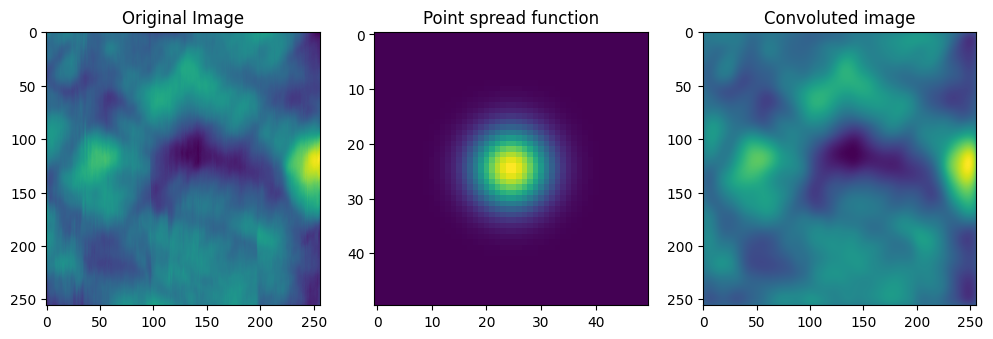

In [225]:
image = images[0]
image = image_linear_correction(image)

psf = gaussian_2d(center = [0, 0], sigma=[0.2, 0.2])

convoluted_image = convoluted_image = conv2(image, psf, 'same')

fig, ax = plt.subplots(1, 3, figsize = (12, 7))

ax[0].imshow(image)
ax[0].set_title("Original Image")

ax[1].imshow(psf)
ax[1].set_title("Point spread function")

ax[2].imshow(convoluted_image)
ax[2].set_title("Convoluted image")

plt.show()

Double Tip

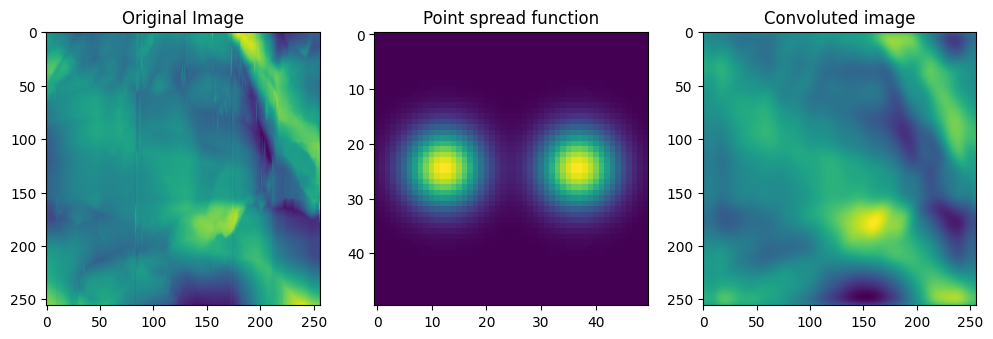

In [148]:
image = images[1]
image = image_linear_correction(image)

psf = double_tip(center1=[-0.5, 0], center2 = [0.5, 0], r_tip1=0.1, r_tip2=0.1)

convoluted_image = convoluted_image = conv2(image, psf, 'same')

fig, ax = plt.subplots(1, 3, figsize = (12, 7))

ax[0].imshow(image)
ax[0].set_title("Original Image")

ax[1].imshow(psf)
ax[1].set_title("Point spread function")

ax[2].imshow(convoluted_image)
ax[2].set_title("Convoluted image")

plt.show()

# convolution dataset -  for training

In [226]:
original_images, convoluted_images  = generate_convolution_training_data(images, psf)

Save dataset

In [ ]:
# Save datasets
# Create a new HDF5 file
with h5py.File('convolution_afm_data.h5', 'w') as h5f:
    # Create datasets for original and convoluted images
    h5f.create_dataset('image_names', data=image_names)
    h5f.create_dataset('original_images', data=np.array(original_images))
    h5f.create_dataset('convoluted_images', data=np.array(convoluted_images))
h5f.close()

In [ ]:
# Deconvolutions

# Deconvolution

Here we use the Richardson-Lucy (RL) deconvolution


In [227]:
from skimage import color, data, restoration

In [228]:
orig_image = original_images[0]
convoluted_image = convoluted_images[0]

In [256]:
def pad_psf(image, psf):
    psf_padded = np.zeros_like(image)
    psf_center = (psf_padded.shape[0] // 2, psf_padded.shape[1] // 2)
    psf_padded[psf_center[0]-psf.shape[0]//2:psf_center[0]+psf.shape[0]//2, psf_center[1]-psf.shape[1]//2:psf_center[1]+psf.shape[1]//2] = psf
    # psf_padded = np.roll(psf_padded, -psf_center[0], axis=0)
    # psf_padded = np.roll(psf_padded, -psf_center[1], axis=1)

    return psf_padded

def pad_image(image, factor = 2):
    image=  np.asarray(image)
    shape0, shape1 = int(image.shape[0]), int(image.shape[1])
    img_padded = np.zeros(shape = [shape0*factor, shape1*factor])
    img_center = (img_padded.shape[0] // 2, img_padded.shape[1] // 2)
    img_padded[img_center[0]-image.shape[0]//2:img_center[0]+image.shape[0]//2, img_center[1]-image.shape[1]//2:img_center[1]+image.shape[1]//2] = image

    return img_padded



def central_image(orig_image, scaled_image, factor = 2):
    image=  np.asarray(orig_image)
    # shape0, shape1 = int(image.shape[0]), int(image.shape[1])
    # img_padded = np.zeros(shape = [shape0*factor, shape1*factor])

    img_center = (scaled_image.shape[0] // 2, scaled_image.shape[1] // 2)
    central_image = scaled_image[img_center[0]-image.shape[0]//2:img_center[0]+image.shape[0]//2, img_center[1]-image.shape[1]//2:img_center[1]+image.shape[1]//2]
    central_image = np.asarray(central_image)

    return central_image

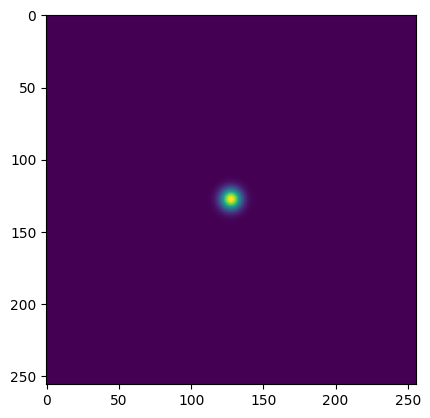

In [251]:
psf_padded = pad_psf(convoluted_image, psf)
plt.imshow(psf_padded)

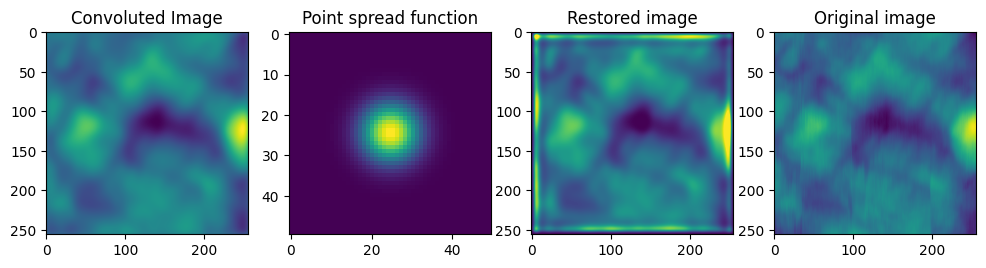

In [257]:
padded_convoluted_image = pad_image(convoluted_image)
psf_padded = pad_psf(padded_convoluted_image, psf)

restored_image = restoration.richardson_lucy(padded_convoluted_image, psf_padded, num_iter=10)
restored_image = central_image(convoluted_image, restored_image)

fig, ax = plt.subplots(1, 4, figsize = (12, 7))

ax[0].imshow(convoluted_image)
ax[0].set_title("Convoluted Image")

ax[1].imshow(psf)
ax[1].set_title("Point spread function")

ax[2].imshow(restored_image)
ax[2].set_title("Restored image")

ax[3].imshow(orig_image)
ax[3].set_title("Original image")

plt.show()